CreatedBy - Garvit Kumar Arya

Date - 22 August 2021

# **Sklearn**

In [3]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold


In [4]:
print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))


numpy: 1.21.1
pandas: 1.3.1
matplotlib: 3.4.3
seaborn: 0.11.2
sklearn: 0.24.2


In [5]:
df = pd.read_csv("/home/garvit/Documents/work_area/Anaconda_Workspace/misc/MLOps with MLFlow/archive/creditcard.csv")

## Data Processing

In [9]:
normal = df[df['Class'] == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df['Class'] == 1]

In [10]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 31)
Anomaly: (492, 31)


In [12]:
# train-test split

normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

In [13]:
# validation split

normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [16]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])


# droping label column from data to treat as features
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [17]:
print("Training sets:\nx_train: {} y_train: {}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} y_test: {}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} y_validate:{}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 30) y_train: (85588,)

Testing sets:
x_test: (28531, 30) y_test: (28531,)

Validation sets:
x_validate: (28531, 30) y_validate:(28531,)


In [19]:
# normalizing the data

scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop('Class', axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

## Model Training

In [25]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg').fit(x_train, y_train)


## Model Evaluation

In [27]:
eval_acc = sk_model.score(x_test, y_test)
print(eval_acc)

0.9986681153832673


In [28]:
preds = sk_model.predict(x_test)
auc_score = roc_auc_score(y_test, preds)

print(f"Auc Score: {auc_score:.3%}")
print(f"Eval Accuracy: {eval_acc:.3%}")

Auc Score: 84.331%
Eval Accuracy: 99.867%


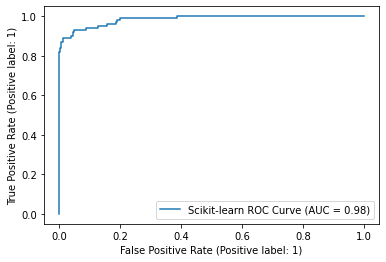

In [29]:
roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')


Text(0.5, 15.0, 'Actual')

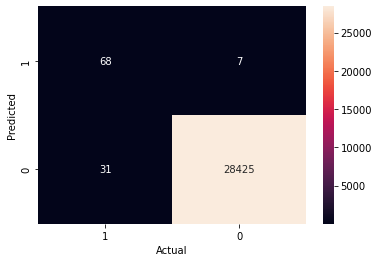

In [39]:
conf_matrix = confusion_matrix(y_test, preds).T
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Predicted')
plt.xlabel('Actual')

## Model Validation

In [45]:
anomaly_weights = [1, 5, 10, 15]

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [47]:
logs = []

for f in range(len(anomaly_weights)):
        fold = 1
        accuracies = []
        auc_scores= []
        for train, test in kfold.split(x_validate, y_validate):
            weight = anomaly_weights[f]
            class_weights={0:1,
                           1: weight
                           }
            
            sk_model = LogisticRegression(random_state=None, 
                                          max_iter=400, 
                                          solver='newton-cg',
                                          class_weight=class_weights).fit(x_validate[train], y_validate[train])

            
            for h in range(40): print('-', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")

            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1

            print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))

            accuracies.append(eval_acc)
            auc_scores.append(auc_score)

            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)

            fold = fold + 1
print("\nAverages: ")
print("Accuracy: ", np.mean(accuracies))
print("AUC: ", np.mean(auc_scores))
print("Best: ")
print("Accuracy: ", np.max(accuracies))
print("AUC: ", np.max(auc_scores))

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
eval_acc: 0.9980722046968104
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomaly Weight: 5
AUC: 0.9314663169342972
eval_acc: 0.9987732211706976
----------------------------------------
fold 4
Anomaly Weight: 

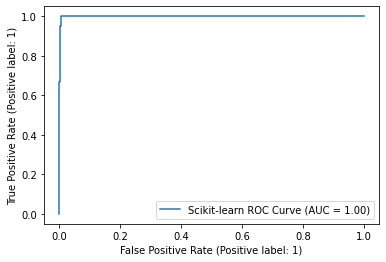

In [48]:
sk_model, x_val, y_val, preds = logs[11]
roc_plot = plot_roc_curve(sk_model, x_val, y_val, name='Scikit-learn ROC Curve')

Text(33.0, 0.5, 'Predicted')

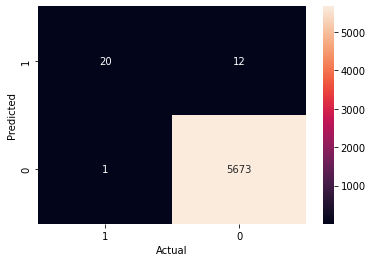

In [49]:
conf_matrix = confusion_matrix(y_val, preds).T
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel('Actual')
plt.ylabel('Predicted')

# **PySpark**

In [4]:
!python --version

Python 3.8.11


In [6]:
import findspark

findspark.init()

## Data Processing

In [7]:
import pyspark #
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F

import os
import seaborn as sns
import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib #
import matplotlib.pyplot as plt

In [8]:
os.environ["SPARK_LOCAL_IP"] = '127.0.0.1'

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()

print("pyspark: {}".format(pyspark.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))

21/08/20 21:31:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


pyspark: 3.1.2
matplotlib: 3.4.3
seaborn: 0.11.2
sklearn: 0.24.2


In [9]:
data_path = "/home/garvit/Documents/work_area/Anaconda_Workspace/misc/MLOps with MLFlow/archive/creditcard.csv"
df = spark.read.csv(data_path, header = True, inferSchema = True)

labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [11]:
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

dfFeatures = df.select(F.col(labelColumn).alias('label'), *numericCols )

normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")

normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed = 2020)

In [28]:
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

In [30]:
pipeline = Pipeline(stages= stages)
pipelineModel = pipeline.fit(dfFeatures)

train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)

print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

Training Dataset Count:  114389


Test Dataset Count:  28459


## Model Training

In [34]:
lr = LogisticRegressionPySpark(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

21/08/21 14:27:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/08/21 14:27:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


## Model Evaluation

In [35]:
predictions = lrModel.transform(test)

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 93.722%
PySpark AUC Score: 98.271%
Accuracy Score: 99.909%


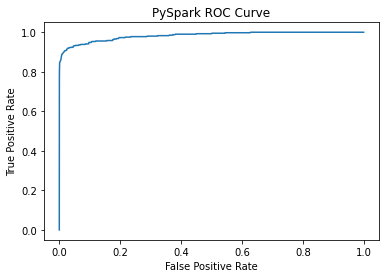

In [36]:
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])


Text(33.0, 0.5, 'Predicted')

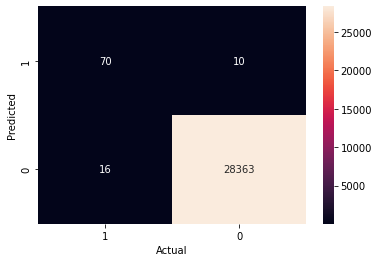

In [37]:
conf_matrix = confusion_matrix(y_true, y_pred).T
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel('Actual')
plt.ylabel('Predicted')